In [ ]:
try:
  %tensorflow_version 2.x
except:
  pass

In [ ]:
import os
import zipfile
import random
from shutil import copyfile
from shutil import rmtree
from urllib import request

In [ ]:
# Download dataset
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
dataset_zip_name = "cats_vs_dogs.zip"
request.urlretrieve(dataset_url, dataset_zip_name)

('cats_vs_dogs.zip', <http.client.HTTPMessage at 0x7f718d6a8d90>)

In [ ]:
# Unzip dataset
working_dir = "/tmp"
zip_file = zipfile.ZipFile(dataset_zip_name)
zip_file.extractall(working_dir)
zip_file.close()

In [ ]:
org_dataset_name = "PetImages"
org_dataset_path = os.path.join(working_dir, org_dataset_name)

for cls in os.listdir(org_dataset_path):
  cls_path = os.path.join(org_dataset_path, cls)
  print(f"Number of {cls}: {len(os.listdir(cls_path))}")

# Expected Output:
# Number of cat images: 12501
# Number of dog images: 12501

Number of Dog: 12501
Number of Cat: 12501


In [ ]:
dataset_name = "cats_vs_dogs"
dataset_path = os.path.join(working_dir, dataset_name)
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

if os.path.exists(dataset_path):
    rmtree(dataset_path)

os.mkdir(dataset_path)
os.mkdir(train_dir)
os.mkdir(test_dir)
cls_train_dirs = []
cls_test_dirs = []
for cls in os.listdir(org_dataset_path):
    cls_train_dir = os.path.join(train_dir, cls)
    cls_test_dir = os.path.join(test_dir, cls)
    os.makedirs(cls_train_dir, exist_ok=False)
    os.makedirs(cls_test_dir, exist_ok=False)
    cls_train_dirs.append(cls_train_dir)
    cls_test_dirs.append(cls_test_dir)  

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)
        
split_size = .9

for idx in range(len(cls_train_dirs)):
  cls = os.path.basename(cls_train_dirs[idx])
  split_data(os.path.join(org_dataset_path, cls),
             cls_train_dirs[idx],
             cls_test_dirs[idx], 
             split_size)
  
# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

11702.jpg is zero length, so ignoring.
666.jpg is zero length, so ignoring.


In [ ]:
for idx in range(len(cls_train_dirs)):
    cls = os.path.basename(cls_train_dirs[idx])
    print(f"Number of training {cls} images {len(os.listdir(cls_train_dirs[idx]))}" )

for idx in range(len(cls_test_dirs)):
    cls = os.path.basename(cls_test_dirs[idx])
    print(f"Number of testing {cls} images {len(os.listdir(cls_test_dirs[idx]))}" )

# expected output
# Number of training cat images 11250
# Number of training dog images 11250
# Number of testing cat images 1250
# Number of testing dog images 1250

Number of training Dog images 11250
Number of training Cat images 11250
Number of testing Dog images 1250
Number of testing Cat images 1250


In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7f718c3df990>)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150, 150, 3), 
                    include_top=False, 
                    weights=None)
pre_trained_model.load_weights(weights_file)
for layer in pre_trained_model.layers:
    layer.trainable=False
  
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
print(f'last layer output shape: {last_output.shape}')

last layer output shape: (None, 7, 7, 768)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
x = layers.Flatten()(last_output)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dense(units=1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), 
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=2, 
                    verbose=1)

Epoch 1/2
207/225 [==========================>...] - ETA: 1:11 - loss: 0.1349 - acc: 0.9436

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 976s 4s/step - loss: 0.1347 - acc: 0.9436 - val_loss: 0.0740 - val_acc: 0.9748
Epoch 2/2
225/225 [==============================] - 957s 4s/step - loss: 0.1183 - acc: 0.9501 - val_loss: 0.0715 - val_acc: 0.9760


Text(0.5, 1.0, 'Training and validation accuracy')

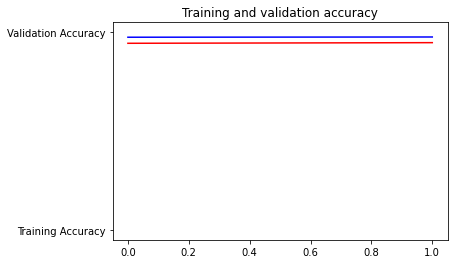

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  classes = model.predict(x)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving istockphoto-1257840867-1024x1024.jpg to istockphoto-1257840867-1024x1024 (2).jpg
[[1.]]
[1.]
istockphoto-1257840867-1024x1024.jpg is a dog
